# Load Related Libraries

In [20]:
import torch, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools, os, sys
from scipy.stats import entropy,gaussian_kde
from src.metrics import *
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_rows', None)

# Define functions

In [ ]:
def kl_divergence(p, q):    
    p = p / (np.sum(p))
    q = q / (np.sum(q))
    return entropy(p, q)
    
def compute_kl_divergence(data, s1_data, s2_data, bins=50, range_min=40, range_max=400):
    merge_data = np.concatenate([data,s1_data,s2_data])
    _range = (min(merge_data), max(merge_data))
    
    data_hist, _ = np.histogram(data, bins=bins, range=_range, density=True)
    s1_hist, _ = np.histogram(s1_data, bins=bins, range=_range, density=True)
    s2_hist, _ = np.histogram(s2_data, bins=bins, range=_range, density=True)

    eps = 1e-10
    kl_data_s1 = kl_divergence(data_hist, s1_hist+eps)
    kl_data_s2 = kl_divergence(data_hist, s2_hist+eps)

    return {
        'kl_data_s1': kl_data_s1,
        'kl_data_s2': kl_data_s2
    }

def moving_average_filter(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def calculate_snr_cgm(cgm_data, window_size=5):
    estimated_signal = moving_average_filter(cgm_data, window_size)
    noise = cgm_data - estimated_signal  # 잡음 추출

    signal_power = np.mean(estimated_signal ** 2)
    noise_power = np.mean(noise ** 2)

    snr_db = 10 * np.log10(signal_power / noise_power)
    return snr_db

def get_dist_ratio(cgm):
    N, N_hypo, N_hyper = len(cgm), sum((cgm<70)*1), sum((cgm>=180)*1)
    N_normo = N - (N_hypo + N_hyper)
    TBR, TIR, TAR = (N_hypo*100/N), (N_normo*100/N), (N_hyper*100/N)

    return TBR, TIR, TAR

# Load Datasets

In [2]:
sim_data1 = torch.load('Datasets/Sim_Data_1/Processed/Data_CGM+IOB.pt')
sim_data2 = torch.load('Datasets/Sim_Data_2/Processed/Data_CGM+IOB.pt')

diatrend_data = torch.load('Datasets/DiaTrend/Combined/cgm+ins+iob.pt')
shanghai_data = torch.load('Datasets/ShanghaiT1DM/Combined/cgm+ins+iob.pt')

ohio_data_train = torch.load('Datasets/OhioT1DM/Combined/train/cgm+ins+iob.pt')
ohio_data_test = torch.load('Datasets/OhioT1DM/Combined/test/cgm+ins+iob.pt')
ohio_data = []
for d1, d2 in zip(ohio_data_train, ohio_data_test):
    d = pd.concat([d1, d2])
    ohio_data.append(d)
    print(d2.SID.unique()[0], len(d2))

2018_588 288
2020_540 570
2018_591 1439
2018_563 288
2020_552 576
2020_544 864
2020_584 846
2018_575 576
2020_596 1997
2018_570 1693
2018_559 576


# Visualization & Analysis

========== HTD ==========
N: 10
TBR: 19.2, TIR: 66.9, TAR: 13.9
GRI: 7974.26%, CV: 52.62
========== LTD ==========
N: 10
TBR: 2.8, TIR: 74.7, TAR: 22.5
GRI: 4448.69%, CV: 41.07


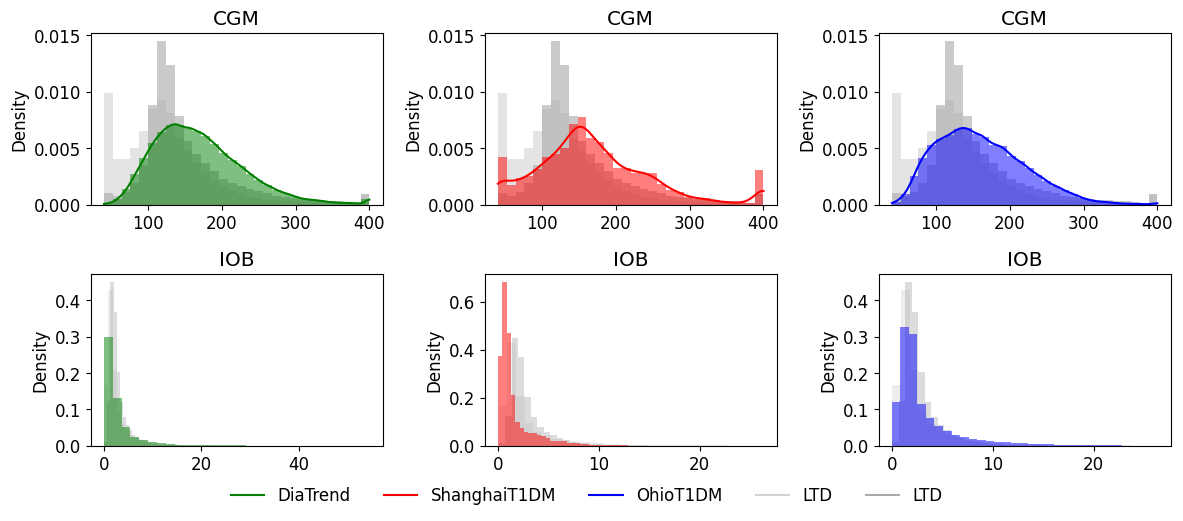

In [5]:
plt.rc('font', size=12)
data_name_list = ['HTD', 'LTD']
for i, data in enumerate([sim_data1, sim_data2]):
    CGM, INS = data[:, :, 0].reshape(-1).numpy(), data[:, :, 1].reshape(-1).numpy()

    N, N_hypo, N_hyper = len(CGM), sum((CGM < 70) * 1), sum((CGM >= 180) * 1)
    N_normo = N - (N_hypo + N_hyper)
    TBR, TIR, TAR = (N_hypo * 100 / N), (N_normo * 100 / N), (N_hyper * 100 / N)
    
    print('='*10, f'{data_name_list[i]}', '='*10)
    print(f"N: {len(data)}")
    print(f"TBR: {TBR:.1f}, TIR: {TIR:.1f}, TAR: {TAR:.1f}")
    print(f"GRI: {get_GRI(CGM) * 100:.2f}%, CV: {get_CV(CGM):.2f}")

s1_cgm, s1_ins = sim_data1[:, :, 0].reshape(-1), sim_data1[:, :, 1].reshape(-1)
s2_cgm, s2_ins = sim_data2[:, :, 0].reshape(-1), sim_data2[:, :, 1].reshape(-1)

data_name_list = ['DiaTrend', 'ShanghaiT1DM', 'OhioT1DM']
color_list = ['green', 'red', 'blue']

plt.figure(figsize=(12, 5))
cnt = 1
for i, data in enumerate([diatrend_data, shanghai_data, ohio_data]):
    CGM, INS = [], []
    for ii in range(len(data)):
        CGM.extend(data[ii].CGM)
        INS.extend(data[ii].IOB)
    CGM, INS = np.array(CGM), np.array(INS)

    plt.subplot(2, 3, cnt)
    sns.histplot(s1_cgm, bins=30, color='lightgrey', label='HTD', kde=False, stat="density", alpha=0.6, edgecolor=None)
    sns.histplot(s2_cgm, bins=30, color='darkgrey', label='LTD', kde=False, stat="density", alpha=0.6, edgecolor=None)
    sns.histplot(CGM, bins=30, color=color_list[i], label=f'{data_name_list[i]}', kde=True, stat="density", alpha=0.5, edgecolor=None)
    plt.title('CGM')

    plt.subplot(2, 3, cnt + 3)
    sns.histplot(s1_ins, bins=30, color='lightgrey', label='HTD', kde=False, stat="density", alpha=0.4, edgecolor=None)
    sns.histplot(s2_ins, bins=30, color='darkgrey', label='LTD', kde=False, stat="density", alpha=0.4, edgecolor=None)
    sns.histplot(INS, bins=30, color=color_list[i], label=f'{data_name_list[i]}', kde=False, stat="density", alpha=0.5, edgecolor=None)
    plt.title('IOB')

    cnt += 1

handles, labels = [], []
for i, data_name in enumerate(data_name_list):
    handles.append(plt.Line2D([], [], color=color_list[i], label=data_name))
handles.append(plt.Line2D([], [], color='lightgrey', label='LTD'))
handles.append(plt.Line2D([], [], color='darkgrey', label='LTD'))

plt.tight_layout()


plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(-1.0, -0.15), ncol=5, frameon=False)

plt.show()


In [28]:
data_name_list = ['Sim-Data-1', 'Sim-Data-2']
data_rows = []

for i, data in enumerate([sim_data1, sim_data2]):    
    for ii in range(len(data)):
        cgm, ins = data[ii,:,0].numpy(), data[ii,:,1].numpy()

        N, N_hypo, N_hyper = len(cgm), sum((cgm<70)*1), sum((cgm>=180)*1)
        N_normo = N - (N_hypo + N_hyper)
        TBR, TIR, TAR = (N_hypo*100/N), (N_normo*100/N), (N_hyper*100/N)

        snr_db = calculate_snr_cgm(cgm)

        data_rows.append({
            "Data Name": data_name_list[i],
            "SID": f"adult#00{ii}",
            "N": N,
            "TBR (%)": TBR,
            "TIR (%)": TIR,
            "TAR (%)": TAR,
            "GRI (%)": get_GRI(cgm),
            "CV": get_CV(cgm),
            "SNR (dB)": snr_db  # SNR 추가
        })

df = pd.DataFrame(data_rows)
display(df.drop(columns = ['SID']).groupby('Data Name').agg(['mean','std']).round(2))


N      TBR (%)       TIR (%)       TAR (%)       GRI (%)  \
               mean  std    mean   std    mean   std    mean   std    mean   
Data Name                                                                    
Sim-Data-1  17569.0  0.0   19.16  3.67   66.93  7.25   13.91  5.71   79.74   
Sim-Data-2  17569.0  0.0    2.83  1.14   74.67  7.51   22.50  6.90   44.49   

                      CV       SNR (dB)        
              std   mean   std     mean   std  
Data Name                                      
Sim-Data-1  15.37  50.87  6.52    40.30  0.68  
Sim-Data-2  13.02  39.05  6.32    40.41  0.74

In [29]:
data_name_list = ['DiaTrend', 'ShanghaiT1DM', 'OhioT1DM']
data_rows = []

for i, data in enumerate([diatrend_data, shanghai_data, ohio_data]):    
    for ii in range(len(data)):
        sid = data[ii].head().SID.unique()[0]
        cgm, ins = data[ii].CGM, data[ii].IOB

        N, N_hypo, N_hyper = len(cgm), sum((cgm<70)*1), sum((cgm>=180)*1)
        N_normo = N - (N_hypo + N_hyper)
        TBR, TIR, TAR = (N_hypo*100/N), (N_normo*100/N), (N_hyper*100/N)

        cgm_kl_div = compute_kl_divergence(cgm, s1_cgm.numpy(), s2_cgm.numpy())
        ins_kl_div = compute_kl_divergence(ins, s1_ins.numpy(), s2_ins.numpy())

        snr_db = calculate_snr_cgm(cgm)
        data_rows.append({
            "Data Name": data_name_list[i],
            "SID": sid,
            "N": N,
            "TBR (%)": TBR,
            "TIR (%)": TIR,
            "TAR (%)": TAR,
            "GRI (%)": get_GRI(cgm),
            "CV": get_CV(cgm),
            "KL-CGM-S1": cgm_kl_div['kl_data_s1'],
            "KL-CGM-S2": cgm_kl_div['kl_data_s2'],
            "KL-INS-S1": ins_kl_div['kl_data_s1'],
            "KL-INS-S2": ins_kl_div['kl_data_s2'],
            "SNR (dB)": snr_db  # SNR 추가
        })

df = pd.DataFrame(data_rows)
df.drop(columns = ['SID', 'N']).groupby('Data Name').agg(['mean']).round(2)

,TBR (%),TIR (%),TAR (%),GRI (%),CV,KL-CGM-S1,KL-CGM-S2,KL-INS-S1,KL-INS-S2,SNR (dB)
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Data Name,,,,,,,,,,
DiaTrend,1.44,61.57,36.98,63.50,33.03,0.49,0.25,0.48,1.00,34.35
OhioT1DM,2.79,63.03,34.19,63.06,35.70,0.38,0.23,0.36,0.60,34.16
ShanghaiT1DM,8.02,55.11,36.87,83.05,37.15,0.64,0.56,0.50,1.84,35.60


In [19]:
data_name_list = ['DiaTrend', 'ShanghaiT1DM', 'OhioT1DM']
data_rows = []

for i, data in enumerate([diatrend_data, shanghai_data, ohio_data]):    
    for ii in range(len(data)):
        if data_name_list[i] == 'OhioT1DM':
            train_cgm = ohio_data_train[ii].CGM[-288*10:]
            train_ins = ohio_data_train[ii].IOB[-288*10:]
            test_cgm = ohio_data_test[ii].CGM
            test_ins = ohio_data_test[ii].IOB
            
            sid = ohio_data_train[ii].head().SID.unique()[0]
        else:
            cgm, ins = data[ii].CGM, data[ii].IOB
            train_cgm = cgm[:288*3]
            train_ins = ins[:288*3]
            test_cgm = cgm[288*3:]
            test_ins = ins[288*3:]
            sid = data[ii].head().SID.unique()[0]


        train_TBR, train_TIR, train_TAR = get_dist_ratio(train_cgm)
        test_TBR, test_TIR, test_TAR = get_dist_ratio(test_cgm)

        train_GRI, test_GRI = get_GRI(train_cgm), get_GRI(test_cgm)
        train_CV, test_CV = get_CV(train_cgm), get_CV(test_cgm)
        
        CV = get_CV(cgm)

        data_rows.append({
            "Data Name": data_name_list[i],
            "SID": sid,
            "N": N,
            "Train-TBR (%)": train_TBR, "Train-TIR (%)": train_TIR, "Train-TAR (%)": train_TAR,
            "Test-TBR (%)": test_TBR, "Test-TIR (%)": test_TIR, "Test-TAR (%)": test_TAR,
            "Train-GRI (%)": train_GRI, "Test-GRI (%)": test_GRI,
            'CV': CV,
            "Train-CV": train_CV, "Test-CV": test_CV,
        })


df = pd.DataFrame(data_rows)
display(df.sort_values(by="SID"))

df.drop(columns = ['SID', 'N']).groupby('Data Name').agg(['mean', 'std'])

,Data Name,SID,N,Train-TBR (%),Train-TIR (%),Train-TAR (%),Test-TBR (%),Test-TIR (%),Test-TAR (%),Train-GRI (%),Test-GRI (%),CV,Train-CV,Test-CV
22,ShanghaiT1DM,1002_1,5165,40.393519,51.041667,8.564815,13.163717,74.115044,12.721239,134.884259,59.845133,49.060608,60.466650,37.399115
17,ShanghaiT1DM,1002_2,5165,15.277778,77.430556,7.291667,7.317073,77.073171,15.609756,57.500000,46.926829,33.245529,33.360711,28.051843
21,ShanghaiT1DM,1003_0,5165,0.000000,67.592593,32.407407,0.000000,78.671329,21.328671,51.851852,34.125874,34.013542,34.740944,31.179029
18,ShanghaiT1DM,1004_0,5165,0.000000,55.092593,44.907407,0.000000,43.967517,56.032483,71.851852,89.651972,27.728049,31.310512,23.765243
23,ShanghaiT1DM,1005_0,5165,32.291667,35.069444,32.638889,5.400697,57.317073,37.282230,149.097222,75.853659,54.429497,63.475743,40.367577
20,ShanghaiT1DM,1008_0,5165,4.629630,27.893519,67.476852,0.000000,47.643979,52.356021,121.851852,83.769634,46.451881,44.216339,30.404391
19,ShanghaiT1DM,1009_0,5165,0.000000,46.875000,53.125000,0.000000,59.069767,40.930233,85.000000,65.488372,23.392031,24.995710,13.917830
24,ShanghaiT1DM,1010_0,5165,0.000000,48.263889,51.736111,1.250000,44.375000,54.375000,82.777778,90.750000,28.862192,29.398261,23.005963
35,OhioT1DM,2018_559,5165,3.645833,57.743056,38.611111,5.729167,59.375000,34.895833,72.715278,73.020833,28.862192,39.798644,40.409938
28,OhioT1DM,2018_563,5165,1.875000,69.826389,28.298611,0.000000,66.319444,33.680556,50.902778,53.888889,28.862192,32.742398,21.645073


Train-TBR (%)            Train-TIR (%)            Train-TAR (%)  \
                      mean        std          mean        std          mean   
Data Name                                                                      
DiaTrend          1.763344   2.127682     55.031318  20.733877     43.205338   
OhioT1DM          2.585227   2.277913     59.277146  13.777092     38.137626   
ShanghaiT1DM     11.574074  16.290043     51.157407  16.047409     37.268519   

                        Test-TBR (%)           Test-TIR (%)             ...  \
                    std         mean       std         mean        std  ...   
Data Name                                                               ...   
DiaTrend      21.387419     1.391674  1.154145    61.957624  15.101134  ...   
OhioT1DM      14.680663     2.594874  2.159253    62.682532  15.923179  ...   
ShanghaiT1DM  21.378271     3.391436  4.862955    60.279110  14.641617  ...   

             Train-GRI (%)            Test-GRI (%)                    CV  \
                      mean        std         mean        std       mean   
Data Name                                                                  
DiaTrend         74.418573  32.525045    62.816146  23.768786  33.028280   
OhioT1DM         68.775884  21.215655    63.340773  24.468205  28.862192   
ShanghaiT1DM     94.351852  36.426358    68.301434  20.564706  37.147916   

                          Train-CV               Test-CV            
                    std       mean        std       mean       std  
Data Name                                                           
DiaTrend       5.039809  30.532944   6.659571  32.915205  5.154048  
OhioT1DM       0.000000  34.679038   5.553853  33.594249  8.248992  
ShanghaiT1DM  11.331331  40.245609  14.501526  28.511374  8.420039  

[3 rows x 22 columns]